In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from torch.utils.data import DataLoader, Dataset
from torchvision.transforms import Compose
from clearml import Task, Logger

In [2]:
import uuid

run_name = f"Run-{uuid.uuid4().hex[:8]}"

task = Task.init(
    project_name="Diploma Multibranch net/VAD",
    task_name=run_name,
    task_type=Task.TaskTypes.training,
)

task.set_system_tags(["gpu_monitoring"])

ClearML Task: created new task id=0ffbf29c10da4b3497715e48650a8250
2025-01-23 18:43:53,312 - clearml.Task - INFO - Storing jupyter notebook directly as code
ClearML results page: https://app.clear.ml/projects/cff53488e12d4c89bbfa21fb6e031b19/experiments/0ffbf29c10da4b3497715e48650a8250/output/log


In [3]:
# Загрузка данных
class ECGDataset(Dataset):
    def __init__(self, data, labels=None, transform=None):
        self.data = data
        # self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        signal = self.data[idx]
        # signal = np.array([signal[i] - np.min(signal[i], axis=0) for i in range(8)])
        # signal = np.array([signal[i] / np.max(signal[i], axis=0) for i in range(8)])
        # label = self.labels[idx]
        if self.transform:
            signal = self.transform(signal)
        return signal

In [4]:
import pickle

with open("../../Data/dumped/X_train_fraction.pkl", "rb") as f:
    f.seek(0)
    X_train = pickle.load(f)
with open("../../Data/dumped/y_train_fraction.pkl", "rb") as f:
    f.seek(0)
    y_train = pickle.load(f)
with open("../../Data/dumped/X_test_fraction.pkl", "rb") as f:
    f.seek(0)
    X_test = pickle.load(f)
with open("../../Data/dumped/y_test_fraction.pkl", "rb") as f:
    f.seek(0)
    y_test = pickle.load(f)


# X = np.concat([X_train, X_test], axis=0)
X = X_train
print(X.shape)
# Y = np.concat([y_train, y_test], axis=0)
Y = y_train
print(Y.shape)

(25908, 8, 5000)
(25908,)


In [5]:
input_dim = 8
hidden_dim = 128
latent_dim = 32
seq_len = 5000
batch_size = 32
learning_rate = 1e-2
momentum = 0.9
weight_decay = 1e-5
epochs = 100

In [6]:
# import os
# import sys
# script_path = os.path.join(os.getcwd(), "../Classifiers/VAD")
# print(script_path)
# sys.path.append(script_path)
import vrae
from importlib import reload

reload(vrae)

<module 'vrae' from '/home/kravchenko.artem/Projects/Diplomas/Classifiers/VAD/vrae.py'>

In [7]:
# Инициализация модели, оптимизатора и потерь
# Инициализация модели, функций потерь и оптимизатора'ArithmeticErro


model = vrae.VRAE(
    sequence_length=seq_len,
    number_of_features=input_dim,
    hidden_size=hidden_dim,
    hidden_layer_depth=1,
    block="GRU",
    latent_length=latent_dim,
    cuda=True,
    batch_size=batch_size,
).to("cuda")
optimizer = optim.SGD(
    model.parameters(), lr=learning_rate, momentum=momentum, weight_decay=weight_decay
)
# optimizer = optim.AdamW(model.parameters(), lr=learning_rate, )
reconstruction_loss_fn = nn.MSELoss()
# kl_div_loss = torch.nn.KLDivLoss()


def loss_function(recon_x, x, mu, logvar):
    # recon_x = recon_x.log()
    recon_loss = reconstruction_loss_fn(recon_x, x)
    kl_divergence = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp()) / x.size(0)
    # kl_divergence = kl_div_loss(recon_x, x)
    return recon_loss, kl_divergence

/home/kravchenko.artem/Projects/Diplomas/.venv/lib/python3.10/site-packages/torch/nn/_reduction.py:51: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


In [8]:
# Датасеты и DataLoader
# (предположим, что data_train и labels_train уже загружены)
transform = Compose([])  # Добавьте сюда аугментации, если нужно
dataset = ECGDataset(X, transform=transform)

data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

In [9]:
# Обучение
model.train()
model.to("cuda")
for epoch in range(epochs):
    epoch_loss = 0
    epoch_loss_recon = 0
    epoch_loss_kl = 0
    for batch in data_loader:
        batch = batch.float()
        batch = batch.permute(2, 0, 1)
        batch = batch.to("cuda")

        optimizer.zero_grad()

        loss, recon_loss, kl_loss, _ = model.compute_loss(batch)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=5)
        optimizer.step()
        epoch_loss += loss.item()

        epoch_loss_recon += recon_loss.item()
        epoch_loss_kl += kl_loss.item()

    # Логгирование метрик
    Logger.current_logger().report_scalar(
        "Recon Loss", "Reconstruction", epoch_loss_recon / len(data_loader), epoch
    )
    Logger.current_logger().report_scalar(
        "KL Loss", "KL Divergence", epoch_loss_kl, epoch
    )
    Logger.current_logger().report_scalar(
        "Total Loss", "KL Divergence", epoch_loss, epoch
    )   
    epoch_loss_recon = epoch_loss_recon / len(data_loader)
    print(
        f"Epoch {epoch+1}/{epochs}, Losses: Recon: {epoch_loss_recon:.4f}, KL: {epoch_loss_kl:.4f}"
    )

# Сохранение модели
torch.save(model.state_dict(), "vad_model.pth")

Epoch 1/100, Losses: Recon: 470525.6347, KL: 22.5183
Epoch 2/100, Losses: Recon: 462938.3259, KL: 22.7929
Epoch 3/100, Losses: Recon: 461022.8280, KL: 22.8421
Epoch 4/100, Losses: Recon: 461775.7900, KL: 22.8845
Epoch 5/100, Losses: Recon: 462322.9534, KL: 22.9296
Epoch 6/100, Losses: Recon: 462206.3540, KL: 22.9179
Epoch 7/100, Losses: Recon: 461493.6237, KL: 22.9144
Epoch 8/100, Losses: Recon: 461934.5737, KL: 22.9029
Epoch 9/100, Losses: Recon: 461944.1866, KL: 22.8988
Epoch 10/100, Losses: Recon: 461637.0822, KL: 22.9207
Epoch 11/100, Losses: Recon: 461032.9275, KL: 22.9179
Epoch 12/100, Losses: Recon: 462200.5200, KL: 22.9065
Epoch 13/100, Losses: Recon: 462209.2569, KL: 22.9237
Epoch 14/100, Losses: Recon: 463258.8577, KL: 22.9282
Epoch 15/100, Losses: Recon: 462219.4352, KL: 22.9076
Epoch 16/100, Losses: Recon: 463174.2433, KL: 22.9122
Epoch 17/100, Losses: Recon: 462832.5751, KL: 22.9303
Epoch 18/100, Losses: Recon: 462105.3970, KL: 22.9399
Epoch 19/100, Losses: Recon: 461500.5

In [10]:
# Сохранение модели
torch.save(model.state_dict(), "model_weights.pth")
task.upload_artifact(name="Model Weights", artifact_object="model_weights.pth")

# Сохранение конфигурации
# task.upload_artifact(name="Config File", artifact_object="config.yaml")

2025-01-23 19:58:06,946 - clearml.frameworks - INFO - Found existing registered model id=f74cd72fe9374df29e13032564044a60 [/home/kravchenko.artem/Projects/Diplomas/Classifiers/VAD/model_weights.pth] reusing it.


True

In [11]:
task.close()

In [12]:
dataset = ECGDataset(X_test)
model.load("model_weights.pth")
z_run = model.transform(dataset)

/home/kravchenko.artem/Projects/Diplomas/.venv/lib/python3.10/site-packages/clearml/binding/frameworks/pytorch_bind.py:253: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ret

/home/kravchenko.artem/Projects/Diplomas/.venv/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning:

'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.



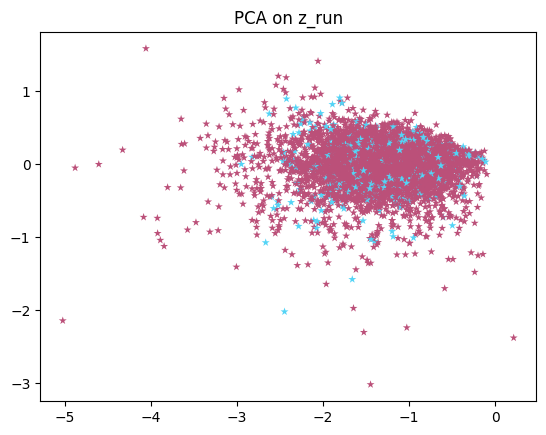

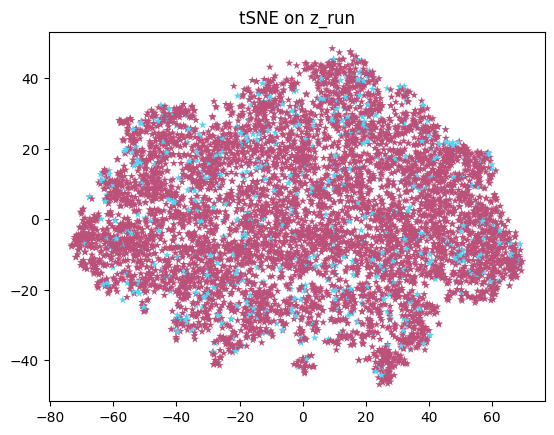

In [13]:
from utils import plot_clustering

plot_clustering(z_run, y_train, engine="matplotlib", download=False)

In [14]:
dataset = ECGDataset(X_test)
model.load("model_weights.pth")
z_run = model.reconstruct(dataset)

/home/kravchenko.artem/Projects/Diplomas/.venv/lib/python3.10/site-packages/clearml/binding/frameworks/pytorch_bind.py:253: FutureWarning:

You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.



In [15]:
z_run = np.swapaxes(z_run, 0, 1)

In [16]:
print(z_run.shape)

(6464, 5000, 8)


(5000, 8)


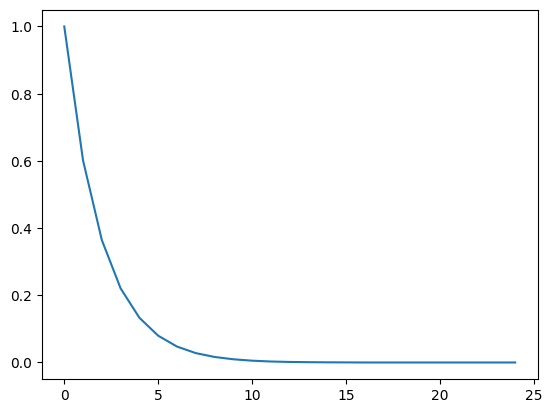

In [17]:
import matplotlib.pyplot as plt

print(z_run[1].shape)

ecg = z_run[1].T[5] - np.min(z_run[1].T[5])
ecg = ecg / np.max(ecg)

plt.plot(ecg[0:25])

In [18]:
from torchview import draw_graph

save_folder = "/home/kravchenko.artem/Projects/Diplomas/Classifiers/VAD/pictures"


model = vrae.VRAE(
    sequence_length=seq_len,
    number_of_features=input_dim,
    hidden_size=hidden_dim,
    hidden_layer_depth=1,
    block="GRU",
    latent_length=latent_dim,
    cuda=False,
    batch_size=batch_size,
)
draw_graph(
    model,
    input_size=(1, 5000, 8),
    expand_nested=True,
    roll=True,
    graph_dir="TB",
    filename=f"model_", 
    directory=str(save_folder),
    save_graph=True,
    device="cpu",
)

/home/kravchenko.artem/Projects/Diplomas/.venv/lib/python3.10/site-packages/torch/nn/_reduction.py:51: UserWarning:

size_average and reduce args will be deprecated, please use reduction='sum' instead.



RuntimeError: Failed to run torchgraph see error message